In [1]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
from scipy.spatial import ConvexHull

In [2]:
def extract_leaf_regions_with_bboxes(image_path, center_landmarks, dilation_iter=5, min_area=500):
    import cv2
    import numpy as np
    from skimage.measure import label, regionprops
    from skimage.morphology import skeletonize
    from scipy.spatial import ConvexHull

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blur = cv2.bilateralFilter(img, 1, 100, 100)

    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inverted = cv2.bitwise_not(thresh)

    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(inverted, kernel, iterations=dilation_iter)

    labeled = label(dilated)
    props = regionprops(labeled)

    landmark_assignments = {}
    for i, (x, y) in enumerate(center_landmarks):
        min_dist = float('inf')
        assigned_label = None
        for region in props:
            if region.area >= min_area:
                cy, cx = region.centroid
                dist = np.hypot(cx - x, cy - y)
                if dist < min_dist:
                    min_dist = dist
                    assigned_label = region.label
        landmark_assignments[i] = assigned_label

    hull_masks = []
    for i, region_idx in landmark_assignments.items():
        if region_idx is None:
            hull_masks.append((None, i, 0))
            continue

        component_mask = (labeled == region_idx).astype(np.uint8)
        coords = np.column_stack(np.where(component_mask > 0))
        if coords.shape[0] < 3:
            hull_masks.append((None, i, 0))
            continue

        hull = ConvexHull(coords)
        hull_pts = coords[hull.vertices]
        hull_mask = np.zeros_like(component_mask)
        cv2.fillConvexPoly(hull_mask, hull_pts[:, [1, 0]], 1)

        area = int(np.sum(hull_mask))
        hull_masks.append((hull_mask, i, area))

    hull_masks.sort(key=lambda x: -x[2])
    final_hull_masks = [None] * len(center_landmarks)
    used_mask = np.zeros_like(img, dtype=bool)

    for hull_mask, idx, _ in hull_masks:
        if hull_mask is None:
            final_hull_masks[idx] = None
            continue
        unique_mask = np.logical_and(hull_mask, ~used_mask)
        used_mask |= unique_mask
        final_hull_masks[idx] = unique_mask.astype(np.uint8)

    outputs = []
    for i, mask in enumerate(final_hull_masks):
        if mask is None or np.count_nonzero(mask) == 0:
            print(f"⚠️ Leaf {i}: Mask is empty or missing, skipping.")
            outputs.append((None, None, None, None, i))
            continue

        coords = np.column_stack(np.where(mask > 0))
        if coords.shape[0] == 0:
            print(f"⚠️ Leaf {i}: No pixels found in mask.")
            outputs.append((None, None, None, None, i))
            continue

        min_row, min_col = coords.min(axis=0)
        max_row, max_col = coords.max(axis=0)
        bbox = (min_row, min_col, max_row, max_col)

        grayscale_crop = img[min_row:max_row+1, min_col:max_col+1] * mask[min_row:max_row+1, min_col:max_col+1]
        threshold_crop = inverted[min_row:max_row+1, min_col:max_col+1] * mask[min_row:max_row+1, min_col:max_col+1]
        mask_crop = mask[min_row:max_row+1, min_col:max_col+1]

        outputs.append((grayscale_crop, threshold_crop, mask_crop, bbox, i))

    return outputs


In [3]:
center_landmarks = np.loadtxt("middle_pts.txt")  # shape (N, 2)
leaf_outputs = extract_leaf_regions_with_bboxes("test.jp2", center_landmarks)

for grayscale, thresholded, mask, bbox, idx in leaf_outputs:
    if grayscale is None:
        print(f"Leaf {idx} skipped (not found or too small).")
        continue
    print(f"Leaf {idx} bbox: {bbox}, grayscale shape: {grayscale.shape}")


⚠️ Leaf 7: Mask is empty or missing, skipping.
Leaf 0 bbox: (380, 228, 736, 608), grayscale shape: (357, 381)
Leaf 1 bbox: (384, 636, 765, 850), grayscale shape: (382, 215)
Leaf 2 bbox: (390, 862, 948, 1101), grayscale shape: (559, 240)
Leaf 3 bbox: (831, 234, 1228, 563), grayscale shape: (398, 330)
Leaf 4 bbox: (1280, 222, 1606, 460), grayscale shape: (327, 239)
Leaf 5 bbox: (1708, 230, 2048, 534), grayscale shape: (341, 305)
Leaf 6 bbox: (381, 1085, 2010, 1566), grayscale shape: (1630, 482)
Leaf 7 skipped (not found or too small).
Leaf 8 bbox: (374, 1630, 920, 2208), grayscale shape: (547, 579)
Leaf 9 bbox: (372, 2206, 1118, 2612), grayscale shape: (747, 407)
Leaf 10 bbox: (974, 1674, 1425, 2081), grayscale shape: (452, 408)
Leaf 11 bbox: (1162, 2184, 2230, 2620), grayscale shape: (1069, 437)
Leaf 12 bbox: (1432, 1609, 2155, 2087), grayscale shape: (724, 479)
Leaf 13 bbox: (999, 576, 2322, 1003), grayscale shape: (1324, 428)
Leaf 14 bbox: (2154, 225, 3568, 457), grayscale shape: (141

In [5]:
leaf_outputs[7]

(None, None, None, None, 7)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.graph import route_through_array
from scipy.ndimage import distance_transform_edt
import cv2

def compute_leaf_path_frequency_map(
    grayscale,
    thresholded,
    mask,
    base_point_global,
    bbox,
    max_paths=1000,
    exponent=4.0,
    center_exponent=6.0,
    clahe_contrast=True,
    visualize=False,
    seed=42
):
    """
    Compute a frequency map of MCP paths from randomly sampled thresholded pixels to a base point.
    Returns: frequency_map (same shape as input leaf image)
    """
    np.random.seed(seed)

    min_row, min_col, max_row, max_col = bbox
    leaf_shape = grayscale.shape

    # Convert global base point to local crop coordinates
    base_row, base_col = base_point_global
    local_base = np.array([base_row - min_row, base_col - min_col])

    # Fallback: find nearest pixel inside mask if base is outside
    if not (0 <= local_base[0] < leaf_shape[0]) or not (0 <= local_base[1] < leaf_shape[1]) or mask[tuple(local_base)] == 0:
        mask_coords = np.column_stack(np.where(mask > 0))
        dists = np.linalg.norm(mask_coords - local_base, axis=1)
        local_base = mask_coords[np.argmin(dists)]

    # Optional: enhance grayscale contrast using CLAHE
    if clahe_contrast:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        grayscale = clahe.apply(grayscale.astype(np.uint8))

    # Normalize grayscale to [0, 1]
    norm_gray = grayscale.astype(np.float32) / 255.0
    norm_gray = 1.0 - norm_gray + 1e-3  # Darker veins have lower cost
    gray_cost = norm_gray ** exponent

    # Emphasize vein centers using distance transform
    dist_to_edge = distance_transform_edt(mask)
    if dist_to_edge.max() > 0:
        dist_norm = dist_to_edge / dist_to_edge.max()
        center_bonus = dist_norm ** center_exponent
    else:
        center_bonus = np.ones_like(dist_to_edge)

    # Final cost: low in center of veins, high elsewhere
    cost_array = gray_cost / center_bonus+ 1e-6
    cost_array[mask == 0] = 1e6  # Strong penalty for background

    # Find thresholded points and sample from them
    candidate_coords = np.column_stack(np.where(thresholded > 0))
    if len(candidate_coords) == 0:
        print("No thresholded pixels found.")
        return None

    if len(candidate_coords) > max_paths:
        sampled_indices = np.random.choice(len(candidate_coords), max_paths, replace=False)
        sampled_coords = candidate_coords[sampled_indices]
    else:
        sampled_coords = candidate_coords

    # Sort sampled coordinates by distance to base (closer first)
    dists_to_base = np.linalg.norm(sampled_coords - local_base, axis=1)
    sorted_coords = sampled_coords[np.argsort(dists_to_base)]

    frequency_map = np.zeros_like(grayscale, dtype=np.uint32)

    for i, coord in enumerate(sorted_coords):
        try:
            path, cost = route_through_array(cost_array, coord, local_base, fully_connected=True)
            path = np.array(path)
            frequency_map[path[:, 0], path[:, 1]] += 1
        except Exception:
            continue  # skip bad paths

    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(grayscale, cmap='gray')
        axes[0].set_title("Grayscale Input")
        axes[1].imshow(cost_array, cmap='magma')
        axes[1].set_title("Cost Landscape")
        axes[2].imshow(frequency_map, cmap='hot')
        axes[2].set_title("Path Frequency Map")
        for ax in axes:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    return frequency_map


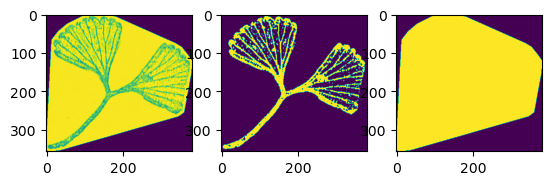

In [32]:
# Single leaf test
i = 0  # index of leaf
grayscale, thresholded, mask, bbox, index = leaf_outputs[i]
base_landmarks = np.loadtxt("base_pts.txt")  # (N, 2)
base_pt = base_landmarks[i]  # (x, y) in global coordinates

plt.subplot(1,3,1)
plt.imshow(grayscale)
plt.subplot(1,3,2)
plt.imshow(thresholded)
plt.subplot(1,3,3)
plt.imshow(mask)

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_4383/3651264450.py:58: RuntimeWarning: divide by zero encountered in divide
  cost_array = gray_cost / center_bonus+ 1e-6


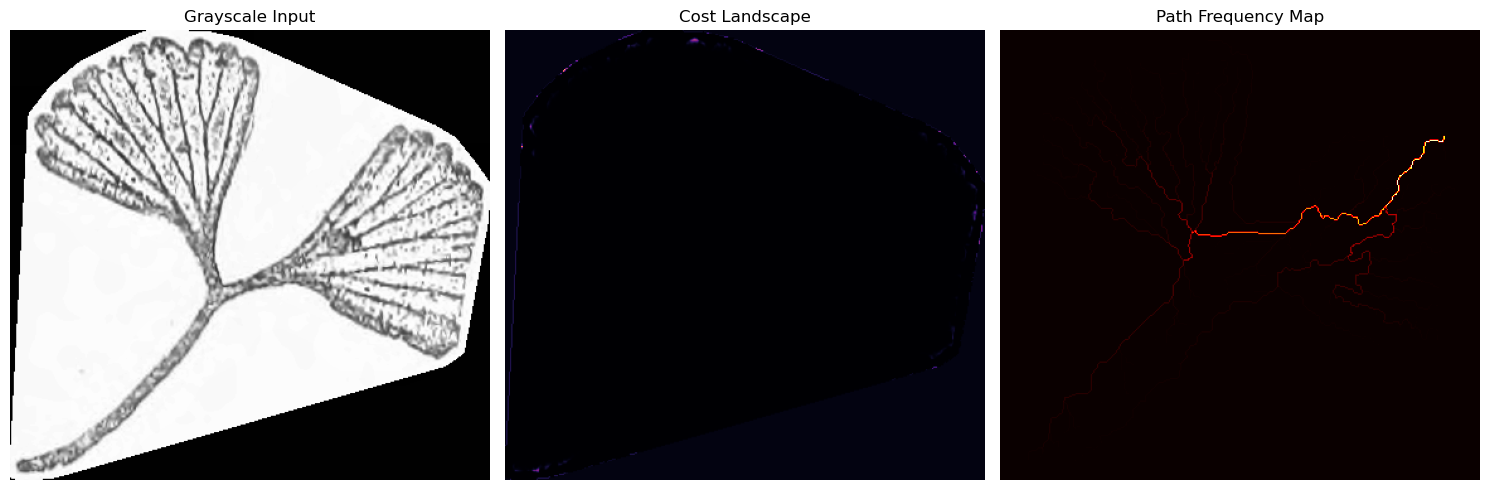

In [33]:
base_landmarks = np.loadtxt("base_pts.txt")  # (N, 2)
base_point_global = base_landmarks[i]



freq_map = compute_leaf_path_frequency_map(
        grayscale,
        thresholded,
        mask,
        base_point_global,
        bbox,
        max_paths=1000,
        exponent=4.0,
        center_exponent=6.0,
        clahe_contrast=True,
        visualize=True  # Turn off for batch mode
    )


(-0.5, 380.5, 356.5, -0.5)

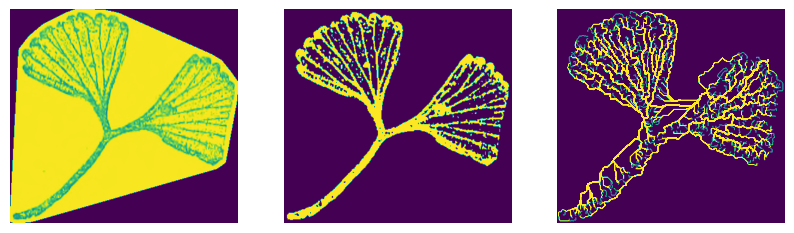

In [36]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(grayscale)
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(thresholded)
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(freq_map, vmin=0, vmax=1, )
plt.axis("off")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.graph import route_through_array
from scipy.spatial.distance import cdist
import cv2

In [ ]:
import numpy as np
from skimage.graph import route_through_array
from skimage.morphology import skeletonize
import cv2
import matplotlib.pyplot as plt

def compute_all_leaf_path_frequency_maps(
    leaf_outputs,
    base_points,
    gamma=3.0,
    decrement=0.0,
    visualize=False
):
    """
    Computes path frequency maps for all leaves in an image.
    
    Parameters:
        leaf_outputs (list): Output of extract_leaf_regions_with_bboxes.
        base_points (np.ndarray): Array of shape (N, 2), base points (x, y) for each leaf.
        gamma (float): Exponent for enhancing contrast of grayscale image.
        decrement (float): Amount to reduce cost along used paths.
        visualize (bool): Whether to visualize each frequency map.

    Returns:
        results: List of (frequency_map, bbox, idx) for each leaf.
    """
    results = []
    
    for leaf_data, base_pt in zip(leaf_outputs, base_points):
        grayscale, thresholded, mask, bbox, idx = leaf_data
        
        if grayscale is None or thresholded is None:
            results.append((None, bbox, idx))
            continue
        
        # Step 1: Prepare cost array (inverted grayscale + gamma)
        cost = 255 - grayscale
        cost = cost.astype(np.float32)
        cost = (cost / 255) ** gamma
        cost[cost == 1.0] = 0.9999  # avoid issues if all are 1

        # Step 2: Identify thresholded pixels to trace from
        trace_mask = (thresholded > 0)
        coords = np.column_stack(np.where(trace_mask))

        if coords.size == 0:
            results.append((None, bbox, idx))
            continue

        # Step 3: Order pixels by distance to base point
        base_yx = np.array([int(base_pt[1]), int(base_pt[0])])
        distances = np.linalg.norm(coords - base_yx, axis=1)
        ordered_coords = coords[np.argsort(distances)]

        # Step 4: Initialize path frequency map
        freq_map = np.zeros_like(grayscale, dtype=np.uint32)

        for i, start in enumerate(ordered_coords):
            try:
                path, _ = route_through_array(cost, start, base_yx, fully_connected=True)
                path = np.array(path)

                for y, x in path:
                    freq_map[y, x] += 1
                    if decrement > 0:
                        cost[y, x] = max(cost[y, x] - decrement, 0.001)

            except Exception:
                continue  # skip unreachable pixels

            if i % 100 == 0:
                print(f"Leaf {idx}: traced {i}/{len(ordered_coords)} paths")

        if visualize:
            plt.figure(figsize=(6, 6))
            # Apply logarithmic scaling for visibility
            log_map = np.log1p(freq_map.astype(np.float32))  # log(1 + x)
            plt.imshow(freq_map, cmap='magma')
            plt.title(f"Leaf {idx} Path Frequency Map")
            plt.axis('off')
            plt.show()

        results.append((freq_map, bbox, idx))

    return results


In [ ]:
import numpy as np

# Load base and middle points
base_landmarks = np.loadtxt("base_pts.txt")  # (N, 2)
center_landmarks = np.loadtxt("middle_pts.txt")  # (N, 2)

# Extract masked leaves and bounding boxes
leaf_outputs = extract_leaf_regions_with_bboxes("test.jp2", center_landmarks)

# Compute path frequency maps
results = compute_all_leaf_path_frequency_maps(
    leaf_outputs,
    base_landmarks,
    gamma=3.0,
    decrement=0.01,
    visualize=True
)